In [ ]:
# !pip install kaggle pandas tensorflow

   ---------------------------------------- 0.0/181.2 kB ? eta -:--:--
   --------------------------------- ------ 153.6/181.2 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 181.2/181.2 kB 2.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/163.4 kB ? eta -:--:--
   ---------------------------------------- 163.4/163.4 kB 9.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.2 kB ? eta -:--:--
   ---------------------------------------- 78.2/78.2 kB 4.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = r'C:\Users\max77\.kaggle'
import shutil
import pandas as pd
from tqdm import tqdm

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# Télécharger le dataset CelebA
api.dataset_download_files('jessicali9530/celeba-dataset', path='celeba_image', unzip=True)

# Chemins
base_dir = 'celeba_image'
img_dir = os.path.join(base_dir, 'img_align_celeba', 'img_align_celeba')
attr_file = os.path.join(base_dir, 'list_attr_celeba.csv')
output_dir = os.path.join(base_dir, 'smile_split')

NUM_SAMPLES = 25000  # ← Modifie ici pour plus/moins

# Lire les attributs
df = pd.read_csv(attr_file)
df.set_index('image_id', inplace=True)

df_sampled = df.sample(n=NUM_SAMPLES, random_state=0)

# Créer les dossiers
os.makedirs(os.path.join(output_dir, 'smiling'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'not_smiling'), exist_ok=True)

# Copier les images dans les bons dossiers
for img_name, row in tqdm(df.iterrows(), total=len(df)):
    smile = row['Smiling']
    src_path = os.path.join(img_dir, img_name)
    if not os.path.exists(src_path):
        continue

    if smile == 1:
        dst_path = os.path.join(output_dir, 'smiling', img_name)
    else:
        dst_path = os.path.join(output_dir, 'not_smiling', img_name)

    shutil.copy(src_path, dst_path)

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset


100%|██████████| 202599/202599 [07:14<00:00, 466.20it/s]


In [5]:
import random
from pathlib import Path
# === CONFIGURATION ===
source_dir = 'celeba_image/smile_split'  # dossier où les images sont déjà triées (smiling / not_smiling)
output_dir = 'celeba_sampled'  # dossier de sortie pour le sous-groupe
samples_per_class = 2500       # nombre d’images à prélever par classe  2500+2500 donc 5000 au total
image_size = (256, 256)        # taille d’image
batch_size = 32
seed = 0

# === ÉTAPES ===

# Crée les dossiers de sortie
for class_name in ['smiling', 'not_smiling']:
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

# Pour chaque classe, sélectionner un échantillon aléatoire
for class_name in ['smiling', 'not_smiling']:
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    sampled = random.sample(images, samples_per_class)

    for img in sampled:
        src = os.path.join(class_path, img)
        dst = os.path.join(output_dir, class_name, img)
        shutil.copy(src, dst)

print("✅ Images copiées avec succès.")

✅ Images copiées avec succès.


In [6]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir,
    validation_split=0.2,   # 80% pour l'entrainement
    subset='training',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    output_dir,
    validation_split=0.2,   # 20% pour la validation
    subset='validation',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.


In [8]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB 640.0 kB/s eta 0:01:01
   ---------------------------------------- 0.2/39.0 MB 2.3 MB/s eta 0:00:18
    --------------------------------------- 0.9/39.0 MB 7.4 MB/s eta 0:00:06
   - -------------------------------------- 1.8/39.0 MB 10.4 MB/s eta 0:00:04
   -- ------------------------------------- 2.6/39.0 MB 12.7 MB/s eta 0:00:03
   --- ------------------------------------ 3.7/39.0 MB 14.6 MB/s eta 0:00:03
   ---- ----------------------------------- 4.6/39.0 MB 15.4 MB/s eta 0:00:03
   ----- ---------------------------------- 5.6/39.0 MB 16.1 MB/s eta 0:00:03
   ------ --------------------------------- 6.6/39.0 MB 16.8 MB/s eta 0:00:02
   ------- -------------------------------- 7.5/39.0 MB 17.2 MB/s eta 0:00:02
   -------- ------------------------------- 8.5/39.0 MB 17.5 MB/s eta 0:00:02
   --------- ------------------------------ 9.5/39.0 MB 17.8 MB/s eta 0:0


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from PIL import Image

# === 1. Charger le dataset
full_ds = tf.keras.utils.image_dataset_from_directory(
    'celeba_sampled',
    image_size=(128, 128),
    batch_size=32,
    seed=0,
    label_mode='binary'
)

# === 2. Split en train, val, test
total_size = full_ds.cardinality().numpy()
test_size = total_size // 10
val_size = total_size // 10
train_size = total_size - test_size - val_size

test_ds = full_ds.take(test_size)
val_ds = full_ds.skip(test_size).take(val_size)
train_ds = full_ds.skip(test_size + val_size)

# === 3. Normalisation
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# === 4. Modèle CNN

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === 5. Vidéo
video_frames = []
TARGET_SIZE = (640, 480)

def add_frame_from_plot(fig):
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    img = img[:, :, :3]
    img = Image.fromarray(img).resize(TARGET_SIZE)
    video_frames.append(np.array(img))

# === 6. Images initiales du dataset
fig, ax = plt.subplots(1, 5, figsize=(12, 3))
for images, labels in train_ds.take(1):
    for i in range(5):
        ax[i].imshow(images[i].numpy())
        ax[i].set_title(f"Label: {int(labels[i])}")
        ax[i].axis('off')
add_frame_from_plot(fig)
plt.close(fig)

# def predict_smile(image_path, model):
#     # Charger l'image et redimensionner
#     img = image.load_img(image_path, target_size=(128, 128))
    
#     # Convertir en array numpy et normaliser
#     img_array = image.img_to_array(img) / 255.0
    
#     # Ajouter une dimension batch
#     img_array = np.expand_dims(img_array, axis=0)
    
#     # Prédire
#     pred = model.predict(img_array)[0][0]
    
#     # Seuil 0.5 pour binaire
#     label = "Smiling" if pred > 0.5 else "Not Smiling"
#     confidence = pred if pred > 0.5 else 1 - pred
    
#     print(f"Prediction: {label} (confidence: {confidence:.2f})")
#     return label, confidence

# === 5. Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.2, min_lr=0.001)
]

# === 7. Entraînement progressif avec prédictions par epoch
EPOCHS = 10
history_all = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}

sample_test_images, sample_test_labels = next(iter(test_ds.take(1)))

for epoch in range(EPOCHS):
    hist = model.fit(train_ds, validation_data=val_ds, epochs=1, verbose=1, callbacks=callbacks)
    
    # Sauvegarder métriques
    history_all["accuracy"].extend(hist.history["accuracy"])
    history_all["val_accuracy"].extend(hist.history["val_accuracy"])
    history_all["loss"].extend(hist.history["loss"])
    history_all["val_loss"].extend(hist.history["val_loss"])
    
    # === Frame 1 : courbes
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(history_all["accuracy"], label='Train Acc')
    ax[0].plot(history_all["val_accuracy"], label='Val Acc')
    ax[0].legend(); ax[0].set_title("Accuracy")
    
    ax[1].plot(history_all["loss"], label='Train Loss')
    ax[1].plot(history_all["val_loss"], label='Val Loss')
    ax[1].legend(); ax[1].set_title("Loss")
    add_frame_from_plot(fig)
    plt.close(fig)
    
    # === Frame 2 : prédictions sur images tests
    preds = model.predict(sample_test_images)
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i in range(5):
        axes[i].imshow(sample_test_images[i].numpy())
        pred_label = "Smiling" if preds[i] > 0.5 else "Not Smiling"
        true_label = "Smiling" if sample_test_labels[i] == 1 else "Not Smiling"
        axes[i].set_title(f"P:{pred_label}\nT:{true_label}")
        axes[i].axis('off')
    add_frame_from_plot(fig)
    plt.close(fig)

# image_path = "C:/Users/max77/OneDrive/Bureau/IPSSI/ML/CNN/celeba_sampled/smiling/005183.jpg"
# label, conf = predict_smile(image_path, model)

# img = Image.open(image_path).resize((128, 128))

# fig, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(img)
# ax.axis('off')
# ax.set_title(f"Prediction: {label}\nConfidence: {conf:.2f}", fontsize=14, color='blue')
# add_frame_from_plot(fig)
# plt.close(fig)

# === 8. Évaluation finale
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true).astype(int).flatten()
y_pred = np.array(y_pred).astype(int).flatten()

# Rapport de classification
print("\n🧪 Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=['Not Smiling', 'Smiling']))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Smiling', 'Smiling'],
            yticklabels=['Not Smiling', 'Smiling'])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Matrice de confusion')
add_frame_from_plot(fig)
plt.close(fig)

# Sauvegarde vidéo
imageio.mimsave("training_progress.mp4", video_frames, fps=0.75)
print("🎥 Vidéo enregistrée sous training_progress.mp4")


Found 5000 files belonging to 2 classes.


c:\Users\max77\OneDrive\Bureau\IPSSI\ML\tf_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 39s 283ms/step - accuracy: 0.5569 - loss: 1.6002 - val_accuracy: 0.4833 - val_loss: 0.7508 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - accuracy: 0.6104 - loss: 0.6813 - val_accuracy: 0.5979 - val_loss: 0.6843 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 36s 285ms/step - accuracy: 0.6277 - loss: 0.6414 - val_accuracy: 0.7042 - val_loss: 0.5640 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 44s 343ms/step - accuracy: 0.7233 - loss: 0.5078 - val_accuracy: 0.7271 - val_loss: 0.5670 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 49s 382ms/step - accuracy: 0.7537 - loss: 0.4584 - val_accuracy: 0.8125 - val_loss: 0.4350 - learning_rate: 0.0010
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - accuracy: 0.8020 - loss: 0.4057 - val_acc

In [ ]:
# video_frames = []

# def add_frame_from_plot(fig):
#     fig.canvas.draw()
#     img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
#     img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
#     img = img[:, :, :3]
#     img = Image.fromarray(img).resize(TARGET_SIZE)
#     video_frames.append(np.array(img))

def predict_smile(image_path, model):
    # Charger l'image et redimensionner
    img = image.load_img(image_path, target_size=(128, 128))
    
    # Convertir en array numpy et normaliser
    img_array = image.img_to_array(img) / 255.0
    
    # Ajouter une dimension batch
    img_array = np.expand_dims(img_array, axis=0)
    
    # Prédire
    pred = model.predict(img_array)[0][0]
    
    # Seuil 0.5 pour binaire
    label = "Smiling" if pred > 0.5 else "Not Smiling"
    confidence = pred if pred > 0.5 else 1 - pred
    
    print(f"Prediction: {label} (confidence: {confidence:.2f})")
    return label, confidence

image_path = "C:/Users/max77/OneDrive/Bureau/IPSSI/ML/CNN/celeba_sampled/smiling/090403.jpg"
label, conf = predict_smile(image_path, model)

img = Image.open(image_path).resize((128, 128))

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img)
ax.axis('off')
ax.set_title(f"Prediction: {label}\nConfidence: {conf:.2f}", fontsize=14, color='blue')
add_frame_from_plot(fig)
plt.close(fig)

# Sauvegarde vidéo
imageio.mimsave("prediction_test.mp4", video_frames, fps=0.75)
print("🎥 Vidéo enregistrée sous training_progress.mp4")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Prediction: Not Smiling (confidence: 0.94)
🎥 Vidéo enregistrée sous training_progress.mp4


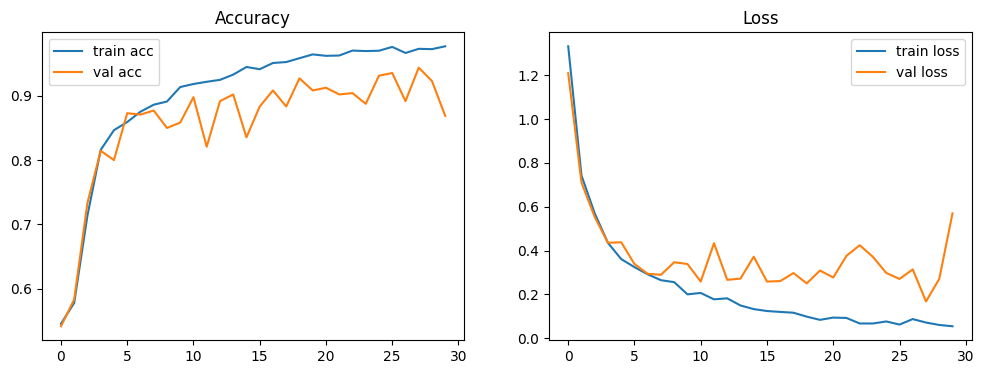

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# # 📌 Callback pour arrêter tôt si la val_loss stagne
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=2,           # nb d'époques sans amélioration avant arrêt
#     restore_best_weights=True
# )

# # 📌 Callback pour réduire le learning rate si la val_loss stagne
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=2,
#     min_lr=1e-6
# )

# # 📌 (Optionnel) Sauvegarder le meilleur modèle selon val_loss
# model_checkpoint = ModelCheckpoint(
#     'best_model.keras',
#     monitor='val_loss',
#     save_best_only=True
# )

In [ ]:
# from tensorflow.keras import layers, models

# model = models.Sequential([
#     layers.Input(shape=(256, 256, 3)),
#     layers.Rescaling(1./255),
#     layers.Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same',),
#     # BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'),
#     # BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'),
#     # BatchNormalization(),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     # layers.Dense(128, activation='relu'),
#     # layers.Dropout(0,1),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0,1),
#     layers.Dense(1, activation='sigmoid')   # 0 = not_smiling / 1 = smiling
# ])

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # === ENTRAÎNEMENT ===
# history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stopping, reduce_lr, model_checkpoint])

NameError: name 'BatchNormalization' is not defined

In [ ]:
# !pip install seaborn 

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
